In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets('MNIST_Data')
import tensorflow as tf

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Data\train-labels-idx1-ubyte.gz
Extracting MNIST_Data\t10k-images-idx3-ubyte.gz
Extracting MNIST_Data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def model_inputs(real_dim,z_dim):
    inputs_real=tf.placeholder(tf.float32,(None,real_dim),name='input_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    return inputs_real,inputs_z

In [3]:
def generator(z,out_dim,n_units=128,reuse=False,alpha=0.01):
    with tf.variable_scope('generator',reuse=reuse):
        h1=tf.layers.dense(z,n_units,activation=None)
        h1=tf.maximum(alpha*h1,h1)
        logits=tf.layers.dense(h1,out_dim,activation=None)
        out=tf.tanh(logits)
        
        return out

In [4]:
def discriminator(x,n_units=128,reuse=False,alpha=0.01):
    with tf.variable_scope('discriminator',reuse=reuse):
        h1=tf.layers.dense(x,n_units,activation=None)
        h1=tf.maximum(alpha*h1,h1)
        logits=tf.layers.dense(h1,1,activation=None)
        out=tf.sigmoid(logits)
        
        return out,logits

In [5]:
input_size=784
z_size=100
g_hidden_size=128
d_hidden_size=128
alpha=0.01
smooth=0.01

In [6]:
tf.reset_default_graph()
input_real,input_z=model_inputs(input_size,z_size)
g_model=generator(input_z,input_size,n_units=g_hidden_size,alpha=alpha)
d_model_real,d_logits_real=discriminator(input_real,n_units=d_hidden_size,alpha=alpha)
d_model_fake,d_logits_fake=discriminator(g_model,reuse=True,n_units=d_hidden_size,alpha=alpha)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                    labels=tf.ones_like(d_logits_real)*(1-smooth)))
d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                    labels=tf.zeros_like(d_logits_real)))
d_loss=d_loss_real+d_loss_fake
g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                    labels=tf.ones_like(d_logits_fake)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
learning_rate=0.002
t_vars=tf.trainable_variables()
g_vars=[var for var in t_vars if var.name.startswith('generator')]
d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
d_train_opt=tf.train.AdamOptimizer(learning_rate).minimize(d_loss,var_list=d_vars)
g_train_opt=tf.train.AdamOptimizer(learning_rate).minimize(g_loss,var_list=g_vars)

In [9]:
import numpy as np
import pickle as pkl
batch_size=100
epochs=100
samples=[]
losses=[]
saver=tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch=mnist.train.next_batch(batch_size)
            
            batch_images=batch[0].reshape((batch_size,784))
            batch_images=batch_images*2-1
            
            batch_z=np.random.uniform(-1,1,size=(batch_size,z_size))
            
            _=sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z})
            _=sess.run(g_train_opt,feed_dict={input_z:batch_z})
            
        train_loss_d=sess.run(d_loss,{input_z:batch_z,input_real:batch_images})
        train_loss_g=g_loss.eval({input_z:batch_z})
            
        print('epoch {}/{}'.format(e+1,epochs),
                'Discriminator loss: {:,.4f}...'.format(train_loss_d),
                'Generator loss: {:,.4f}...'.format(train_loss_g))
            
        losses.append((train_loss_d,train_loss_g))
            
        sample_z=np.random.uniform(-1,1,size=(16,z_size))
        gen_samples=sess.run(generator(input_z,input_size,n_units=g_hidden_size,reuse=True,
                                       alpha=alpha),feed_dict={input_z:sample_z})
        samples.append(gen_samples)
        saver.save(sess,'./checkpoints/generator.ckpt')
        
with open('train_sample.pkl','wb') as f:
    pkl.dump(samples,f)

epoch 1/100 Discriminator loss: 0.0780... Generator loss: 4.2879...
epoch 2/100 Discriminator loss: 0.4340... Generator loss: 2.1896...
epoch 3/100 Discriminator loss: 3.9832... Generator loss: 4.3000...
epoch 4/100 Discriminator loss: 1.8910... Generator loss: 4.2154...
epoch 5/100 Discriminator loss: 2.8582... Generator loss: 5.9755...
epoch 6/100 Discriminator loss: 2.1085... Generator loss: 0.5685...
epoch 7/100 Discriminator loss: 1.2556... Generator loss: 1.7677...
epoch 8/100 Discriminator loss: 2.0412... Generator loss: 0.7883...
epoch 9/100 Discriminator loss: 0.7613... Generator loss: 2.3232...
epoch 10/100 Discriminator loss: 2.3700... Generator loss: 0.7616...
epoch 11/100 Discriminator loss: 1.1859... Generator loss: 1.1194...
epoch 12/100 Discriminator loss: 0.2684... Generator loss: 3.9777...
epoch 13/100 Discriminator loss: 0.6173... Generator loss: 2.1422...
epoch 14/100 Discriminator loss: 1.0989... Generator loss: 1.3117...
epoch 15/100 Discriminator loss: 1.8807... 

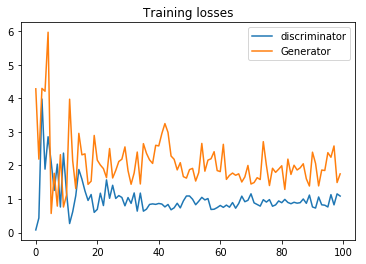

In [10]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
losses=np.array(losses)
plt.plot(losses.T[0],label='discriminator')
plt.plot(losses.T[1],label='Generator')
plt.title('Training losses')
plt.legend()

In [17]:
def view_samples(epoch,samples):
    fig,axes=plt.subplots(figsize=(7,7),nrows=4,ncols=4,sharey=True,sharex=True)
    for ax,img in zip(axes.flatten(),samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im=ax.imshow(img.reshape((28,28)),cmap='Greys_r')
        
    return fig,axes

In [18]:
with open('train_sample.pkl','rb') as f:
    samples=pkl.load(f)

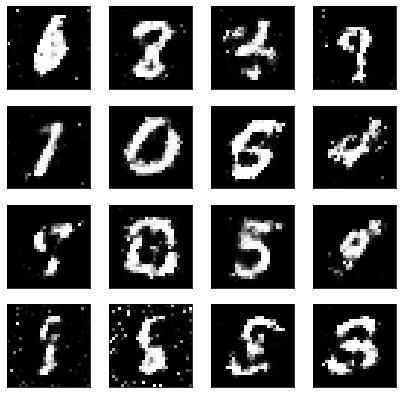

In [19]:
_=view_samples(-1,samples)

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


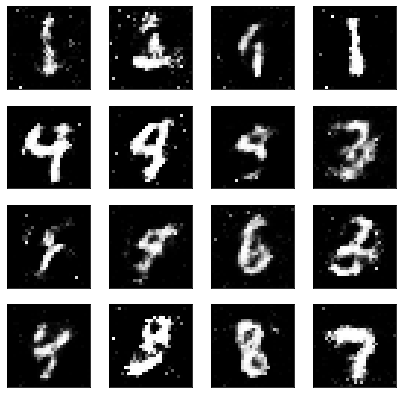

In [20]:
saver=tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    sample_z=np.random.uniform(-1,1,size=(16,z_size))
    gen_samples=sess.run(generator(input_z,input_size,n_units=g_hidden_size,
                                  reuse=True,alpha=alpha),feed_dict={input_z:sample_z})
    
_=view_samples(0,[gen_samples])